## gs_SlidetoIcePipeline01_EffDet

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
import pdb
from datetime import *
import pytz
from random import randint

In [3]:
from icevision.all import *
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

In [4]:
from lib_pipeline_ice_config import *
from lib_pipeline_ice_helper import *

## Display Configuration Parameters (lib_pipeline_config.py)

In [5]:
#Display Config Parameters (edit file)
with open('./lib_pipeline_ice_config.py') as f:
    print(f.read())

from pathlib import Path
from datetime import *
import pytz

params = dict(
    size=512,
    size_trans=512,
    size_progresize=0,
    batch_size=2,
    ds_size=100,
    run='1',
    architecture='CNN',
    modelclass='EffDet',
    infrastructure='unknown',
    )
params.update(project= 'sample_project')
params['model'] = 'tf_efficientdet_d4'
params['run_datetime'] = datetime.now(pytz.timezone('US/Pacific')).strftime("%m%d%Y-%H:%M")

anno_radius = 25 
params['bbox_hw'] = anno_radius

classes = {2:  'mitotic figure'}
class_map_list = ['unkown','mitotic figure']

params.update(class_map=class_map_list)

size = params['size']  
path = Path('./')

dbname = 'MITOS_WSI_CCMCT_ODAEL.sqlite'

#Standalone Paths
path_WSI = '/home/bnapora/development/gsExperimentsCollab/WSI/'
path_Database = '/home/bnapora/development/gsExperimentsCollab/WSI/'

pathWSI = Path(path_WSI)
pathDB = Path(path_Database)

# slidelist_test = ['30']
slidelist_test= '''('30','29')'''

params['dbname'] = dbname


In [6]:
#Pipeline Specific Parameters
params['architecture'] = 'CNN'
params['modelclass'] = 'EffDet'
params['model'] = 'tf_efficientdet_d3'

## Select Annotation Data from SlideRunner DB

In [7]:
slide_count = 4
if slide_count > 0:
    getslides = "SELECT uid, filename FROM Slides LIMIT " + str(slide_count)
else:
    getslides = "SELECT uid, filename FROM Slides"
print(getslides)

SELECT uid, filename FROM Slides LIMIT 4


In [8]:
database = Database()
print(str(pathDB/dbname))
database.open(str(pathDB/dbname))

/home/bnapora/development/gsExperimentsCollab/WSI/MITOS_WSI_CCMCT_ODAEL.sqlite


In [9]:
dir_slides = os.listdir(pathWSI)
database_slides = [s[1] for s in database.execute(getslides).fetchall()]
annotated_and_existing_slides = list(set(dir_slides) & set(database_slides))
slide_list = "', '".join(map(str, annotated_and_existing_slides))

train_slide_query = "SELECT uid, filename FROM Slides WHERE filename IN ('" + slide_list + "')"
print(train_slide_query)

SELECT uid, filename FROM Slides WHERE filename IN ('c3eb4b8382b470dd63a9.svs')


In [10]:
files_train, lbl_bbox_train = get_slide_annotations(database, params['size'], train_slide_query)

## Randomize and Split Annotatation Data

In [11]:
train_images = params['ds_size']
# val_images = int(params['ds_size']*0.2)
test_images = 16

train_files = list(np.random.choice(files_train, train_images))
# valid_files = list(np.random.choice(files_train, val_images))
test_files = list(np.random.choice(files_train, test_images))
print('train_files #:', len(train_files))
print('train_files wdith:', train_files[0].width)

train_files #: 100
train_files wdith: 512


In [12]:
# slide = train_files[0]
# print(slide.width)
# print_properties(slide)

## Load Data

In [13]:
class_map = ClassMap(params['class_map'])

In [14]:
parser = SlideContainerParser(train_files)
train_rs, valid_rs = parser.parse(autofix=True)

INFO     - Autofixing records | icevision.parsers.parser:parse:126



In [15]:
# print(len(train_rs))
# print(len(valid_rs))
# show_records(train_rs[:6], ncols=3, class_map=class_map)

In [16]:
# Transforms
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=params['size'], presize=params['size_trans']), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(params['size']), tfms.A.Normalize()])

In [17]:
# Datasets
train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

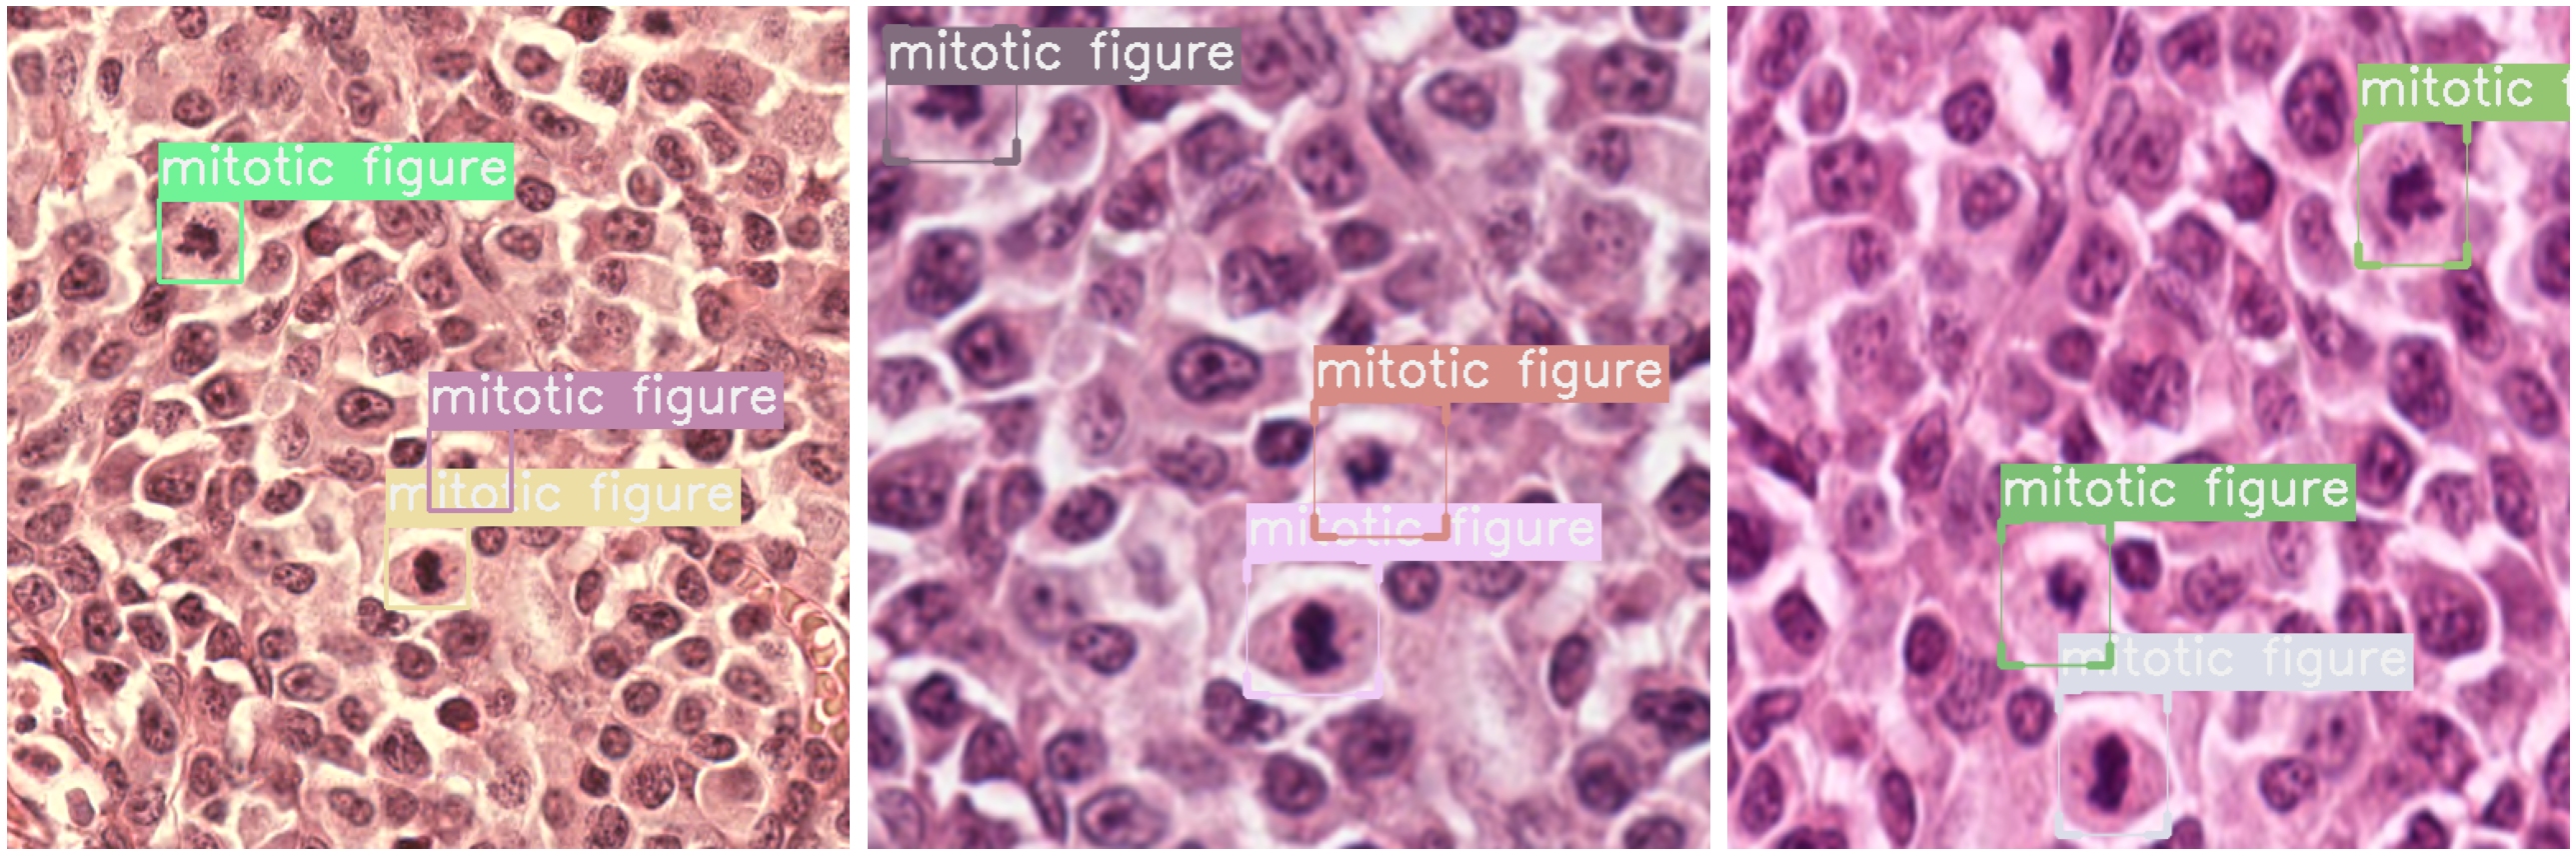

In [18]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=class_map)

In [19]:
# DataLoaders
train_dl = efficientdet.train_dl(train_ds, batch_size=params['batch_size'], num_workers=0, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=params['batch_size'], num_workers=0, shuffle=False)

In [20]:
train_dl.batch_size
valid_dl.batch_size

2

In [21]:
# batch, samples = first(train_dl)
# show_samples(samples[:6], class_map=class_map, ncols=3)

## Model & Parameters Setup

In [22]:
if params['size_progresize'] > 0:
    patchsize = str(params['size_progresize'])
else:
    patchsize = str(params['size'])

params['epochs1'] = 20
params['lr1'] =1e-3
params['epochs2'] = 5
params['lr2'] = 3e-5
params['wandb'] = False

path_model_stage = Path(path/'stages')

params['Run-Notes'] = '1cls Test; Using 40px BBox to compare accuracy'

model_save_name = params['modelclass'] + '_'  
model_save_name += str(len(classes)) + 'cls_' 
model_save_name += str((params['bbox_hw']*2)) + 'bb_'+ patchsize + 'px_' 
model_save_name += str(params['ds_size']) + 'ds_' 
# model_save_name += params['model'] + '_' 
model_save_name += params['run_datetime']
params.update(model_save_name=model_save_name)
print(params['model_save_name'])

EffDet_1cls_50bb_512px_100ds_02152021-15:24


In [23]:
#EfficentDet
#Backbones - Edit model in Config file
# tf_efficientdet_lite0, efficientdet_d0, efficientdet_d1, efficientdet_d2, efficientdet_d3, efficientdet_d4, 
# efficientdet_d5, efficientdet_d6, efficientdet_d7, efficientdet_d7x

model = efficientdet.model(model_name=params['model'], 
                           num_classes=len(params['class_map']), 
                           img_size=params['size'])

In [24]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [25]:
if (params['wandb']==True): 
    WANDB_NOTEBOOK_NAME = 'gs_SlidetoIcePipeline01_EffDet.ipynb'
    wandb.init(project='Test03', name=params['model_save_name'], config=params)
    config = wandb.config

In [26]:
if (params['wandb']==True): 
    callbacks = [WandbCallback(log_preds=True, log_dataset=False, log_model=False)]
else: 
    callbacks = []

In [27]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], cbs = callbacks, model=model, metrics=metrics)

## Model Training - Stage 1

In [28]:
# learn.split([model.encoder[6], model.c5top5])
# learn.freeze_to(-2)

In [ ]:
# learn.freeze()
learn.lr_find()

In [29]:
params.update(lr1 = 1e-3)
params.update (epochs1 = 1)
notes_stage1 = {'Stage1-Lr': params['lr1'], 'Stage1-Ep': params['epochs1']}
notes_stage1['Stage1-Notes'] = {'StartNoes': 'freeze() epochs = None'}

learn.fit_one_cycle(params['epochs1'], params['lr1'], cbs=SaveModelCallback(monitor='COCOMetric'))

Better model found at epoch 0 with COCOMetric value: 0.03733913866128053.


In [ ]:
#Load the Best Model from previous run
learn.load('model')

In [ ]:
# path_model_stage = Path(path/'stages')

In [ ]:
params.update(current_saved_model='stage-1-' + params['model_save_name'])
# print(params['current_saved_model'])
learn.save(path_model_stage/params['current_saved_model'])
notes_stage1['Stage1-Notes'] = {'EndNoes': 'best COCOMetric=0.0.500'}
wandb.log(notes_stage1)

## Stage-2

In [ ]:
#Re-load previous model if Stage-2 degrades model
# params.update(current_saved_model='stage-1-' + str(params['size']) + 'px-' + params['model'])
learn.load(path_model_stage/params['current_saved_model'])

In [ ]:
learn.freeze()
learn.lr_find()

In [ ]:
params.update(lr1 = 1e-5)
params.update (epochs1 = 5)
notes_stage2 = {'Stage2-Lr': params['lr1'], 'Stage2-Ep': params['epochs1']}
notes_stage2['Stage2-Notes'] = {'StartNoes': 'freeze() epochs = False'}

learn.fit_one_cycle(params['epochs1'], params['lr1'], cbs=SaveModelCallback(monitor='COCOMetric'))

In [ ]:
learn.load('model')
params.update(current_saved_model='stage-2-' + params['model_save_name'])
# print(params['current_saved_model'])
learn.save(path_model_stage/params['current_saved_model'])
notes_stage2['Stage2-Notes'] = {'EndNoes': 'best COCOMetric=?'}
wandb.log(notes_stage2)

## Stage-3

In [ ]:
#Re-load previous model if Stage-3 degrades model
params.update(current_saved_model='stage-2-' + str(params['size']) + 'px-' + params['model'])
learn.load(params['current_saved_model'])

In [ ]:
learn.freeze()
learn.lr_find()

In [ ]:
params.update(lr1 = 2e-6)
params.update (epochs1 = 5)
# wandb.log({'lr1': params['lr1'], 'epochs': params['epochs1']})

learn.fit_one_cycle(params['epochs1'], params['lr1'], cbs=SaveModelCallback(monitor='COCOMetric'))

In [ ]:
learn.load('model')

params.update(current_saved_model='stage-3-' + str(params['size']) + 'px-' + params['model'])
print(params['current_saved_model'])
learn.save(params['current_saved_model'])

## Review Model Run - Validation Images

In [ ]:
#Optional - Load preferred saved model from run
learn.load(path_model_stage/params['current_saved_model'])

In [ ]:
efficientdet.show_results(model, valid_ds, class_map=class_map)

## Review Model Run - Test Images

In [ ]:
parser_tst = SlideContainerParser(test_files)
test_rs = parser_tst.parse(data_splitter=SingleSplitSplitter(),autofix=False)

In [ ]:
# show_records(test_rs[0][:6], ncols=3, class_map=class_map)

In [ ]:
test_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(params['size']), tfms.A.Normalize()])
test_ds = Dataset(test_rs[0], test_tfms)

In [ ]:
efficientdet.show_results(model, test_ds, class_map=class_map)

In [ ]:
test_dl = efficientdet.infer_dl(test_ds, batch_size=params['batch_size'])
samples_test, preds_test = efficientdet.predict_dl(model, test_dl)

## Close Wandb Run

In [ ]:
if (params['wandb']==True): 
    wandb_images = wandb_img_preds(samples_test, preds_test, class_map, add_ground_truth=False) 
    wandb.log({"Test Images Prediction-" + str(params['size']) + "px": wandb_images})
    wandb.join()

## Review Model Run - Test Images

In [ ]:
show_records(test_rs[0][:6], ncols=3, class_map=class_map)

In [ ]:
# Show inference on test dataset
imgs = [sample["img"] for sample in samples_test]
imgs=imgs[:2]
show_preds(
    imgs,
    preds=preds_test[:2],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=2,
)

## Export Model/Weights

In [ ]:
# model_folder = params['model_save_name']
path_model = Path(path/'models/final')
path_model_str = str(path_model) #needed for os folder creations
print(path_model)

In [ ]:
# if os.path.exists(path_model_str):
#    shutil.rmtree(path_model_str)
# if not os.path.exists(path_model_str):
#     print(path_model_str)
#     os.mkdir(path_model_str)

In [ ]:
#Save model weights
model_saved = params['model_save_name'] + '.pth'
# torch.save(model.state_dict(), data_dir/'mitosis_tf_efficientdet_lite0.pth')
torch.save(model.state_dict(), path_model/model_saved)
print(path_model/model_saved)

In [ ]:
## Test Predictions from Exported Model

In [ ]:
model2 = efficientdet.model(model_name=params['model'], 
                           num_classes=len(params['class_map']), 
                           img_size=params['size'])
state_dict = torch.load(path_model/model_saved)
model2.load_state_dict(state_dict)

In [ ]:
efficientdet.show_results(model2, test_ds, class_map=class_map)